In [0]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [0]:
X_train = X_train[y_train.flatten() == 2]

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD

import matplotlib.pyplot as plt

import sys

import numpy as np

In [0]:
# Input shape
img_rows = 32
img_cols = 32
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100        
        

In [0]:
def build_generator():

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)


In [0]:
def build_discriminator():

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #no normalization for the first layer 
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

In [0]:
       # Build and compile the discriminator
        discriminator = build_discriminator()
        discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.0002,0.5),
            metrics=['accuracy'])

        # Build the generator
        generator = build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(latent_dim,))
        img = generator(z)

        # For the combined model we will only train the generator
        discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        combined = Model(z, valid)
        combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

In [0]:
def show_imgs(epoch):
        r, c = 4,4
        noise = np.random.normal(0, 1, (r * c,latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()
        

In [0]:
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Validation Losses")
    plt.legend()
    plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.146751] [G loss: 0.570740]


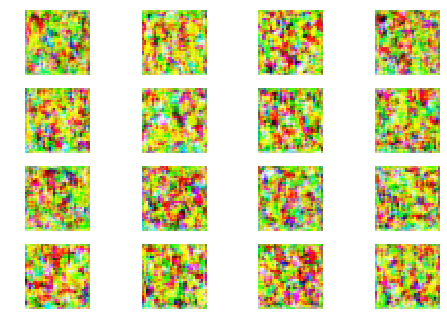

5000 [D loss: 0.419976] [G loss: 1.380879]


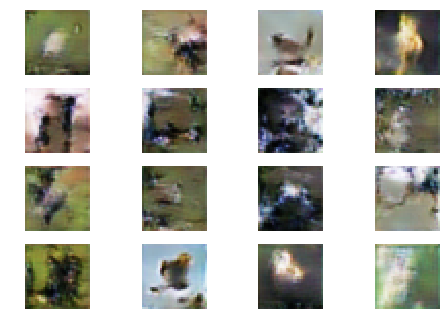

10000 [D loss: 0.807761] [G loss: 1.099059]


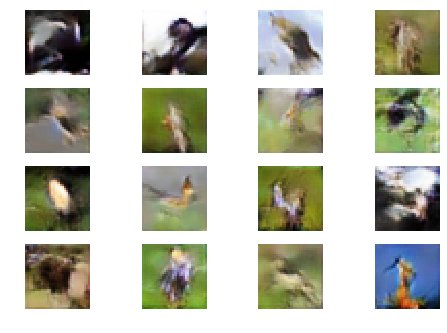

15000 [D loss: 0.308542] [G loss: 1.327352]


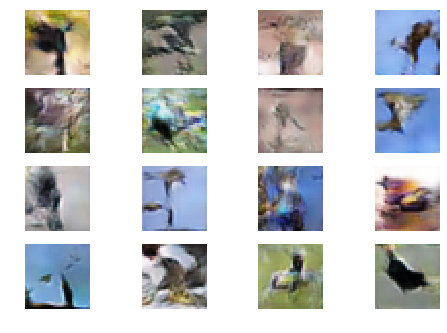

20000 [D loss: 0.531156] [G loss: 1.152678]


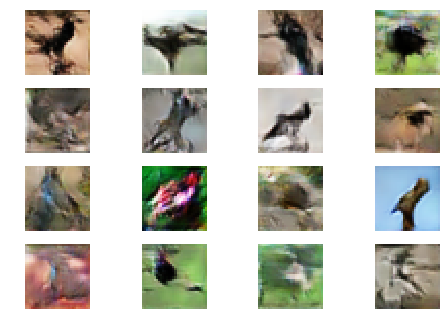

In [25]:
epochs=25000
batch_size=32
display_interval=5000
losses=[]
        # Rescale -1 to 1
X_train = X_train / 127.5 - 1.
        

        # Adversarial ground truths
valid = np.ones((batch_size, 1))
        #let's add some noise 
valid += 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)

for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = combined.train_on_batch(noise, valid)
            
            # Plot the progress
            if epoch % 5000==0:
                print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
                losses.append((d_loss[0],g_loss))
                
            if epoch % display_interval == 0:
                 show_imgs(epoch)
                
 

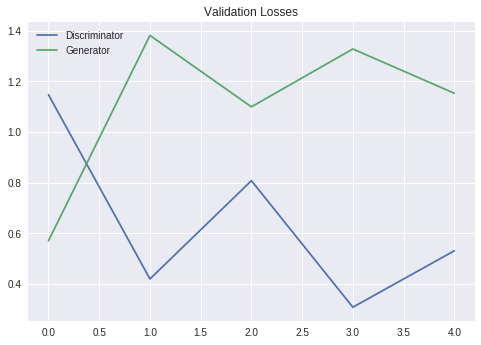

In [26]:
show_losses(losses)

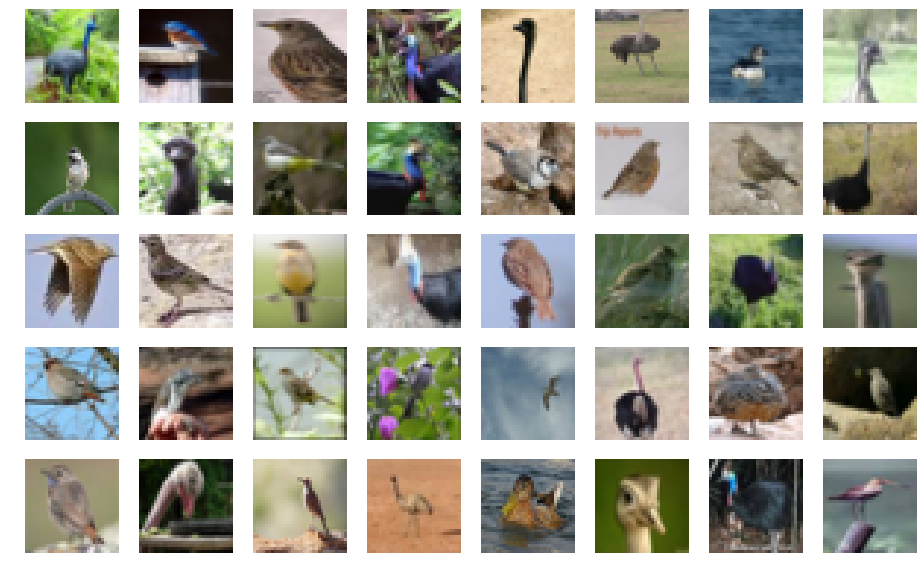

In [29]:
s=X_train[:40]
s = 0.5 * s + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, img in enumerate(s):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

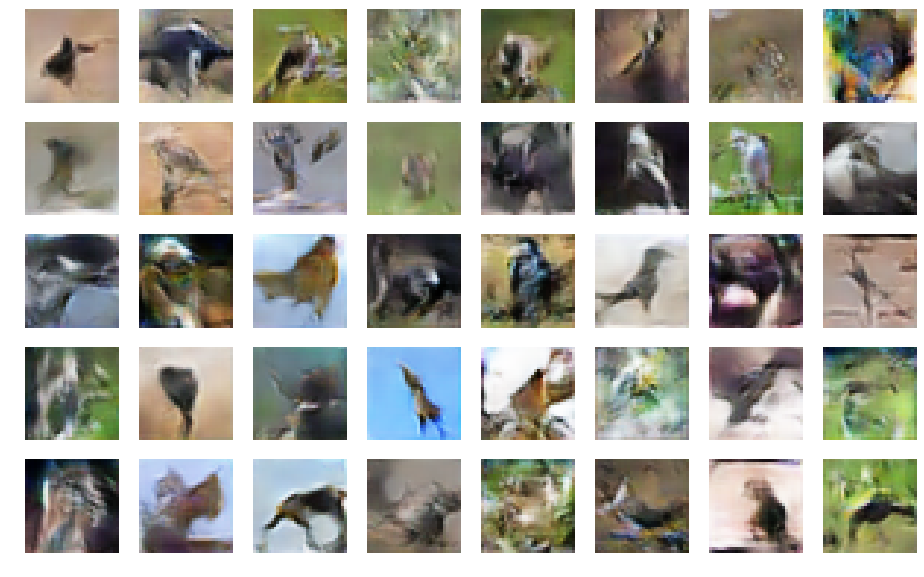

In [37]:
noise = np.random.normal(size=(40, latent_dim))
generated_images = generator.predict(noise)
generated_images = 0.5 * generated_images + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, img in enumerate(generated_images):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()